
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet A2021 : Prédire les maladies cardiaques

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/3a185493d8bb48d8961ad50e465bed4f

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Il faudra que vous trouviez un moyen de traiter les données manquantes. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est appropriée.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.



Ce projet a été réalisé par :

Do, Minh-Tri 2030231

Hage, Jeremy 2014233

Khoueiry, Jean-Paul 2011397

Siclait, Jonathan 2026416

In [667]:
using CSV, DataFrames, Gadfly, GLM, Statistics, Distributions, LinearAlgebra, Random

In [668]:
ENV["COLUMNS"] = 1000;

## 1. Chargement des données

In [669]:
full = CSV.read("train.csv", DataFrame);

In [670]:
full = full[shuffle(1:size(full, 1)),:];

In [671]:
full[!, :FastingBS] = string.(full[:, :FastingBS]);  # Pour que GLM considère la classe comme une variable qualitative

In [672]:
number = size(full, 1);
twoThirds = floor(Int, 2/3*number);

Tout d'abord, nous avons commencé par diviser nos données en échantillon d'entrainement et échantillon de validation. Cette division a été faite en divisant nos données de façon aléatoire en 2/3 pour l'entrainement et 1/3 pour la validation.

In [673]:
data = first(full,twoThirds);

In [674]:
estimate = last(full, number-twoThirds);

Cette fonction a été écrite pour nous permettre de trouver les meilleurs seuils pour diviser nos classes en sous catégories
Le premier seuil maximise les vrais négatifs.
Le deuxième seuil maximise les vrais positifs.
Le troisième seuil maximise le produit de vrais positifs et vrais négatifs.

In [675]:
function findCutoff(table, column, newColumn, lowRange, highRange, nIteration, reverse=false)
    tempTable = select(table, column, newColumn, :HeartDisease)
    maxValue = 0
    maxIt = 0
    minValue = 1.0
    minIt = 0
    minmaxValue = 0
    minmaxIt = 0
    if lowRange >= highRange
        error("range invalid")
    end
    n = size(table, 1)
    for l in 0.0:nIteration
        j = lowRange + ((highRange - lowRange)/nIteration * l) # itère nIteration fois entre lowRange et highRange
        for i in 1:n
            if table[!,column] != Missing && table[!,column][i] < j #selon la valeur de j, on classe les données
                table[!,newColumn][i] = reverse ? "1" : "0" #on swap les classes si c'est inversement proportionnel pour les meilleurs seuils
            else
                table[!,newColumn][i] = reverse ? "0" : "1"
            end
        end
        tempTable = combine(groupby(table, [newColumn]), :HeartDisease => mean => :Odds) 

        if size(tempTable, 1) > 1
            if tempTable.Odds[1] < minValue # on trouve le meilleur seuil pour la classe 0
                minIt = j
                minValue = tempTable.Odds[1]
            end 

            if tempTable.Odds[2] > maxValue # on trouve le meilleur seuil pour la classe 1
                maxIt = j
                maxValue = tempTable.Odds[2] 
            end 

            # on trouve le meilleur seuil pour le produit des 2 classes, pour un seuil acceptable à la fois pour les classes 1 et 2
            if (1 - tempTable.Odds[1]) * tempTable.Odds[2] > minmaxValue && tempTable.Odds[1] != 0 && tempTable.Odds[2] != 1
                minmaxIt = j
                minmaxValue = (1 - tempTable.Odds[1]) * tempTable.Odds[2]
            end 
        end 
    end
    return [[
        minIt,
        minValue],[
        maxIt,
        maxValue],[
        minmaxIt,
        minmaxValue
    ]]
end

findCutoff (generic function with 2 methods)

## 2. Analyse exploratoire sommaire

#### 2.1 Maladie cardiovasculaire en fonction du ChestPainType

Nous avons commencé par séparer notre échantillon en fonction du type de douleur à la poitrine et nous avons trouvé la proportion de patients malades parmi ces groupes.

In [676]:
df = combine(groupby(data, :ChestPainType), :HeartDisease => mean => :Odds)
print(df)

4×2 DataFrame
 Row │ ChestPainType  Odds     
     │ String3        Float64  
─────┼─────────────────────────
   1 │ ASY            0.785124
   2 │ NAP            0.306306
   3 │ ATA            0.152941
   4 │ TA             0.35

Cette séparation nous a permis de constater que les asymptomatiques sont principalement malades et ceux soufrant d'angine de poitrine atypique ne le sont principalement pas.

##### 2.1.1 Maladie cardiovasculaire en fonction du ChestPainType et du sexe

Afin d'améliorer les résultats trouvés plus haut, nous avons ensuite essayé de séparer notre échantillon en fonction du type de douleur à la poitrine et en fonction du sexe du participant.

In [677]:
df = combine(groupby(data, [:ChestPainType, :Sex]), :HeartDisease => mean => :Odds)

,ChestPainType,Sex,Odds
,String3,String1,Float64
1,ASY,M,0.830846
2,ASY,F,0.560976
3,NAP,M,0.379747
4,NAP,F,0.125
5,ATA,M,0.211538
6,ATA,F,0.0606061
7,TA,M,0.5
8,TA,F,0.0


En effectuant cette recherche, nous avons remarqué que les groupes étaient plus définis. En effet, nous avons observé qu'il y a une corrélation entre le sexe et le type de douleur à la poitrine qui permet de déterminer la proportion de maladies cardiaques. C'est donc pour cela que nous avons inclus les deux dans notre modèle.

#### 2.2 Oldpeak en fonction de Maladie cardiovasculaire

Par la suite, nous avons étudié la colonne Oldpeak afin d'évaluer son utilité.

In [678]:
df = combine(groupby(data, [:HeartDisease]), :Oldpeak => mean => :MeanOldPeak)

,HeartDisease,MeanOldPeak
,Int64,Float64
1,0,0.415888
2,1,1.32664


Cette analyse nous a permis de voir que les personnes souffrant de maladies cardiovasculaires ont tendance à avoir des mesures d'électrocardiogramme plus élevées.

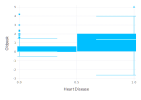

In [679]:
plot(data, x=:HeartDisease, y=:Oldpeak, Geom.boxplot)

En effet, une analyse plus poussée montre que la moyenne des deux diffèrent. Nous avons donc défini un seuil pour séparer cette variable en groupes que nous nommons OldpeakGroups.

In [680]:
data[:, :OldpeakGroups] .= "2"
oldPeakCutoffs = findCutoff(data, :Oldpeak, :OldpeakGroups, 0.0, 2.0, 2000.0)

3-element Vector{Vector{Float64}}:
 [1.4000000000000001, 0.4012738853503185]
 [1.601, 0.8623853211009175]
 [1.601, 0.4917326042953655]

In [681]:
for i in 1:size(data,1)
    if data.Oldpeak[i] < oldPeakCutoffs[3][1]
        data.OldpeakGroups[i] = "0"
    else
        data.OldpeakGroups[i] = "1"
    end
end
df = combine(groupby(data, [:OldpeakGroups]), :HeartDisease => mean => :Odds)

,OldpeakGroups,Odds
,String,Float64
1,0,0.429799
2,1,0.862385


Nous avons donc rajouté la variable OldpeakGroups à notre modèle car nous observons qu'elle sépare assez efficacement les patients en deux groupes, soit le groupe 0 dans lequel les gens ont tendance à être en santé et le groupe 1 dans lequel les gens ont tendance à être malades.

#### 2.3 Maladie cardiovasculaire en fonction de AgeGroups

Ensuite, nous avons étudié la colonne Age afin d'évaluer son utilité.

In [682]:
df = combine(groupby(data, [:HeartDisease]), :Age => mean => :MeanAge)

,HeartDisease,MeanAge
,Int64,Float64
1,0,50.7336
2,1,56.2213


Cette analyse nous a permis de voir que les personnes souffrant de maladies cardiovasculaires ont tendance à être plus vieilles que les gens en santé.

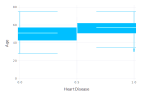

In [683]:
plot(data, x=:HeartDisease, y=:Age, Geom.boxplot)

En effet, une analyse plus poussée montre que la moyenne des deux diffèrent. Nous avons donc défini un seuil pour séparer cette variable en groupes que nous nommons AgeGroups.

In [684]:
data[:, :AgeGroups] .= "2"
ageCutoff = findCutoff(data, :Age, :AgeGroups, 0.0, 100.0, 1000.0)

3-element Vector{Vector{Float64}}:
 [57.1, 0.4340277777777778]
 [71.10000000000001, 0.8]
 [57.1, 0.39618055555555554]

In [685]:
for i in 1:size(data,1)
    if data.Age[i] < ageCutoff[3][1]
        data.AgeGroups[i] = "0"
    else
        data.AgeGroups[i] = "1"
    end
end
df = combine(groupby(data, [:AgeGroups]), :HeartDisease => mean => :Odds)

,AgeGroups,Odds
,String,Float64
1,0,0.434028
2,1,0.7


Nous avons donc rajouté la variable AgeGroups à notre modèle car nous observons qu'elle sépare assez efficacement les patients en deux groupes, soit le groupe 0 dans lequel les gens ont tendance à être en santé et le groupe 1 dans lequel les gens ont tendance à être malades.

#### 2.4 Maladie cardiovasculaire en fonction de Cholesterol

Pour le cholestérol, nous n'avons pas réussi à trouver un seuil qui séparait les patients en deux groupes distincts de gens malades et en santé avec notre fonction findCutoff. La différence entre les deux groupes n'était simplement pas assez significative. Nous avons toutefois remarqué que les gens qui n'avaient pas de valeur de cholestérol étaient très souvent malades alors nous avons séparé notre échantillon en missing versus non-missing.

In [686]:
data[:, :CholesterolGroups] .= "2" 
for i in 1:size(data,1)
    if ismissing(data.Cholesterol[i])
        data.CholesterolGroups[i] = "0"
    else
        data.CholesterolGroups[i] = "1"
    end
end
df = combine(groupby(data, [:CholesterolGroups]), :HeartDisease => mean => :Odds)

,CholesterolGroups,Odds
,String,Float64
1,0,0.897436
2,1,0.457895


Comme on peut voir dans le tableau, notre nouvelle variable CholesterolGroups montre qu'une personne n'ayant pas de valeur de cholestérol a 90% de chances d'être malade comparé à un 40% dans le cas où nous avons la valeur.

#### 2.5 Maladie cardiovasculaire en fonction de MaxHR

Ensuite, nous avons étudié la colonne MaxHR afin d'évaluer son utilité.

In [687]:
combine(groupby(data, :HeartDisease), :MaxHR => mean)

,HeartDisease,MaxHR_mean
,Int64,Float64
1,0,148.598
2,1,127.91


Cette analyse nous a permis de voir que les personnes souffrant de maladies cardiovasculaires ont tendance à avoir une valeur maximale de rythme cardiaque plus élevée.

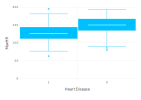

In [688]:
df = select(data, :MaxHR, :HeartDisease)
df.HeartDisease = string.(df.HeartDisease)
plot(df, x=:HeartDisease, y=:MaxHR, Geom.boxplot)

En effet, une analyse plus poussée montre que la moyenne des deux diffèrent. Nous avons donc défini un seuil pour séparer cette variable en groupes que nous nommons MaxHRGroups.

In [689]:
data[:, :MaxHRGroups] .= "2"
maxHRCutoffs = findCutoff(data, :MaxHR, :MaxHRGroups, 50.0, 200.0, 2000.0, true)

3-element Vector{Vector{Float64}}:
 [130.02499999999998, 0.37218045112781956]
 [63.05, 1.0]
 [130.02499999999998, 0.4741345551378447]

In [690]:
for i in 1:size(data,1)
    if(data.MaxHR[i] < maxHRCutoffs[3][1])
        data.MaxHRGroups[i] = "0"
    else
        data.MaxHRGroups[i] = "1"
    end
end

df = combine(groupby(data, :MaxHRGroups), :HeartDisease => mean => :Odds)

,MaxHRGroups,Odds
,String,Float64
1,1,0.37218
2,0,0.755208


Nous avons donc rajouté la variable MaxHRGroups à notre modèle car nous observons qu'elle sépare assez efficacement les patients en deux groupes, soit le groupe 1 dans lequel les gens ont tendance à être en santé et le groupe 0 dans lequel les gens ont tendance à être malades.

#### 2.6 Maladie cardiovasculaire en fonction du sexe

Nous avons décidé ici d'utiliser directement le sexe comme variable, car les hommes semblent souffrir plus souvent de maladies cardiaques que les femmes.

In [691]:
df = combine(groupby(data, :Sex), :HeartDisease => mean => :Odds)
print(df)

2×2 DataFrame
 Row │ Sex      Odds     
     │ String1  Float64  
─────┼───────────────────
   1 │ M        0.621387
   2 │ F        0.258929

#### 2.7 Maladie cardiovasculaire en fonction du électrocardiogramme au repos et de la glycémie à jeun

Après une analyse, nous avons observer que le RestingECG et le FastingBS n'avait pas d'impacts significatifs lorsque l'on les observait seuls. Cependant, lorsqu'évalués ensemble, nous observons qu'ils ont le potentiel d'être de très bons indicateurs de maladie cardiaque.

In [692]:
df = combine(groupby(data, [:RestingECG,:FastingBS]), :HeartDisease => mean => :Odds)
print(df)

6×3 DataFrame
 Row │ RestingECG  FastingBS  Odds     
     │ String7     String     Float64  
─────┼─────────────────────────────────
   1 │ ST          1          0.866667
   2 │ ST          0          0.637931
   3 │ Normal      1          0.775862
   4 │ Normal      0          0.408696
   5 │ LVH         0          0.5
   6 │ LVH         1          0.545455

En effet, lorsque l'on observe les deux variables simultanément, on peut voir que, pour Normal et ST à un FastingBS de 1, on retrouve un impact significatif sur la tendance à souffrir d'une maladie cardiaque. Nous avons donc rajouté ces variables dans notre modèle.

#### 2.8 Maladie cardiovasculaire en fonction de l'angine causée par l'exercice

Nous avons décidé ici d'utiliser directement le l'angine à l'exercice comme variable car ceux qui ont font semblent souffrir plus souvent de maladies cardiaques que ceux qui n'en font pas.

In [693]:
df = combine(groupby(data, :ExerciseAngina), :HeartDisease => mean => :Odds)
print(df)

2×2 DataFrame
 Row │ ExerciseAngina  Odds     
     │ String1         Float64  
─────┼──────────────────────────
   1 │ Y               0.826316
   2 │ N               0.324627

#### 2.9 Maladie cardiovasculaire en fonction de l'angine causée par la pente sur l'électrocardiogramme

De la même façon, nous observons que la variable STSlope est un très bon indicateur de maladie cardiaque. En effet, ceux qui ont des pentes plates ainsi que ceux qui ont des pentes descendantes ont tendance à souffrir de maladies cardiaques.

In [694]:
df = combine(groupby(data, :STSlope), :HeartDisease => mean => :Odds)
print(df)

3×2 DataFrame
 Row │ STSlope  Odds     
     │ String7  Float64  
─────┼───────────────────
   1 │ Flat     0.814978
   2 │ Up       0.169154
   3 │ Down     0.833333

## 3. Ajustement d'un modèle de régression logistique

Nous avons utilisé ces variables pour les raisons que nous avons expliqué plus haut. Nous avons essayé de trouver d'autres liens de corrélation et d'utiliser d'autres variables lors de la réalisation du projet, mais nous n'avons rien trouvé de concluant. Pour confirmer que c'était notre meilleur modèle, nous avons créé un script Python qui nous a écrit un script Julia que nous avons exécuté. Ce script Julia testait toutes les combinaisons des modèles avec les variables utilisées plus haut. Après quelques heures d'exécution, nous avons pu confirmer que celui-ci était notre meilleur modèle en utilisant la métrique du pourcentage de réussite. Nous avons choisis la métrique du pourcentage réussite, car c'est la métrique utilisée sur Kaggle.

In [695]:
M = glm(@formula(HeartDisease ~  ChestPainType + OldpeakGroups + AgeGroups + CholesterolGroups + MaxHRGroups + Sex + RestingECG + FastingBS + ExerciseAngina + STSlope), data,  Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

HeartDisease ~ 1 + ChestPainType + OldpeakGroups + AgeGroups + CholesterolGroups + MaxHRGroups + Sex + RestingECG + FastingBS + ExerciseAngina + STSlope

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error      z  Pr(>|z|)    Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)            1.10884      1.0208     1.09    0.2774  -0.891882     3.10956
ChestPainType: ATA    -1.51754      0.487607  -3.11    0.0019  -2.47324     -0.561852
ChestPainType: NAP    -1.75053      0.390966  -4.48    <1e-05  -2.51681     -0.984251
ChestPainType: TA     -1.11438      0.677889  -1.64    0.1002  -2.44302      0.214255
OldpeakGroups: 1       0.786163

## 4. Prédiction des surverses pour les jours de l'ensemble de test

#### 4.1 Chargement des données de l'ensemble de test

In [696]:
test = CSV.read("test.csv", DataFrame);

#### 4.2 Prédiction pour chacun des patients de l'ensemble de test

In [697]:
test[!, :FastingBS] = string.(test[:, :FastingBS]);  # Pour que GLM considère la classe comme une variable qualitative
test[:, :OldpeakGroups] .= "2"
test[:, :AgeGroups] .= "2"
test[:, :CholesterolGroups] .= "2"
test[:, :MaxHRGroups] .= "2"
for i in 1:size(test,1)
    if test.Oldpeak[i] < oldPeakCutoffs[3][1]
        test.OldpeakGroups[i] = "0"
    else
        test.OldpeakGroups[i] = "1"
    end
    if test.Age[i] < ageCutoff[3][1]
        test.AgeGroups[i] = "0"
    else
        test.AgeGroups[i] = "1"
    end
    if ismissing(test.Cholesterol[i])
        test.CholesterolGroups[i] = "0"
    else
        test.CholesterolGroups[i] = "1"
    end
    if(test.MaxHR[i] < maxHRCutoffs[3][1])
        test.MaxHRGroups[i] = "0"
    else
        test.MaxHRGroups[i] = "1"
    end
end

In [698]:
θ = predict(M, test);

Pour choisir le seuil, nous avons pris l'entièreté de notre code et l'avons mis dans une double boucle. La première boucle définissait le seuil. Nous l'avons fait varier entre 0.3 et 0.7. La deuxième boucle compilait notre code plusieurs fois pour donner une moyenne de notre pourcentage de bonnes prédictions avec chaque seuil. Nous avons utilisé cette technique pour minimiser le risque d'erreur qui aurait pu être causé par le fait que nos données d’entrainement et de test sont définies aléatoirement.

In [699]:
testCutoff = 0.38
Ŷ = zeros(Int64, size(test,1))
Ŷ[θ.>testCutoff] .= 1;

In [700]:
estimate[:, :OldpeakGroups] .= "2"
estimate[:, :AgeGroups] .= "2"
estimate[:, :CholesterolGroups] .= "2"
estimate[:, :MaxHRGroups] .= "2"
for i in 1:size(estimate,1)
    if estimate.Oldpeak[i] < oldPeakCutoffs[3][1]
        estimate.OldpeakGroups[i] = "0"
    else
        estimate.OldpeakGroups[i] = "1"
    end
    if estimate.Age[i] < ageCutoff[3][1]
        estimate.AgeGroups[i] = "0"
    else
        estimate.AgeGroups[i] = "1"
    end
    if ismissing(estimate.Cholesterol[i])
        estimate.CholesterolGroups[i] = "0"
    else
        estimate.CholesterolGroups[i] = "1"
    end
    if(estimate.MaxHR[i] < maxHRCutoffs[3][1])
        estimate.MaxHRGroups[i] = "0"
    else
        estimate.MaxHRGroups[i] = "1"
    end
end

Vu que nous n’avions que deux prédictions par jour à faire sur Kaggle, nous avons partitioné notre jeu de données pour pouvoir faire des tests localement. Le pourcentage trouvé est le pourcentage de précision de notre modèle local.

In [701]:
θestim = predict(M, estimate);

In [702]:
evalua = zeros(Int64, size(estimate,1))
n = size(estimate, 1)
counter = 0

vp = 0
vn = 0
fn = 0
fp = 0

arrayfn = []
arrayfp = []

for i in 1:n
    if (θestim[i] >= testCutoff && estimate[i, :].HeartDisease == 1)
        counter = counter + 1
        vp = vp + 1
    elseif (θestim[i] < testCutoff && estimate[i, :].HeartDisease == 0)
        counter = counter + 1
        vn = vn + 1
    elseif (θestim[i] < testCutoff && estimate[i, :].HeartDisease == 1)
        fn = fn + 1
        push!(arrayfn, i)
    elseif (θestim[i] >= testCutoff && estimate[i, :].HeartDisease == 0)
        fp = fp + 1
        push!(arrayfp, i)
    end
end

println(counter/n)

df = DataFrame(Négatifs_prédits=[vn, fp],Positifs_prédits=[fn, vp])
# 1 représente les négatifs réels
# 2 représente les positifs réels

0.8913043478260869


,Négatifs_prédits,Positifs_prédits
,Int64,Int64
1,89,13
2,12,116


#### 3.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (ID) et d'une colonne des diagnostics prédits.

In [703]:
Prediction = DataFrame(ID = test[:,:ID], Prediction = Ŷ)
CSV.write("benchmark_predictions.csv",Prediction)

"benchmark_predictions.csv"